<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Práctica 1</h3>
<h4 style="text-align: center;">Aurora Zuoris (aurora.zuoris101@alu.ulpgc.es)</h3>

### Ejercicio 1

El United States Census Bureau ha estimado la [población mundial entre 1950 y 2016](https://en.wikipedia.org/wiki/Estimates_of_historical_world_population). Este ejercicio busca encontrar un modelo de crecimiento poblacional lo más ajustado posible estos datos con el que proyectar la población mundial a largo plazo. 

**(a)** Ajustar y validar diversos modelos de crecimiento. Probar con (a) Crecimiento constante; (b) Crecimiento exponencial; (c) Crecimiento logístico; (d) Modelo de Gompertz: $\dot{x}=ax-bxln(x)$, con $a,b>0$; (d) Modelo de Pütter: $\dot{x}=ax^\alpha-bx^\beta$, con $a,b,\alpha,\beta>0$. Medir el error cuadrático medio obtenido con cada modelo.
    
**(b)** Realización una proyección a largo plazo para cada modelo y estimar la población máxima mundial siguiendo ese patrón.

**(c)** Elegir uno de lo modelos como más fiable. Brevemente, dar razones para confiar o no en las proyecciones a largo plazo del modelo. 

### Obtener valores

Primero se descargan los datos

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
import urllib.request
import ssl
import warnings
warnings.filterwarnings('ignore')

# Crear un contexto SSL que no verifique los certificados
context = ssl._create_unverified_context()

# Usar el contexto al abrir la URL
response = urllib.request.urlopen(
    urllib.request.Request(
        'https://en.wikipedia.org/wiki/Estimates_of_historical_world_population',
        headers={
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
        }
    ),
    context=context,
)
html_wiki = response.read()

tables_wiki = pd.read_html(html_wiki,
                   header=0, 
                   index_col=0,
                   decimal='M')

tables_wiki

[                               1400       1500        1600        1700  \
 Year                                                                     
 population (in millions)  350M–400M  430M–500M   500M–580M   600M–680M   
 average annual growth[1]      <0.1%     <0.12%  0.15%–0.3%  0.1%–0.15%   
 
                                1800           1900           2000  \
 Year                                                                
 population (in millions)  890M–980M  1,560M–1,710M  6,060M–6,150M   
 average annual growth[1]  0.3%–0.5%      0.5%–0.6%      1.3%–1.4%   
 
                                         2100  
 Year                                          
 population (in millions)  c. 10,000M–13,000M  
 average annual growth[1]           0.7%–0.8%  ,
        PRB (1973–2016)[15]  UN (2015)[16]  \
 Year                                        
 −10000                 NaN            NaN   
 −9000                  NaN            NaN   
 −8000                   5.            

In [121]:
df = tables_wiki[2]
df.head()

,United States Census Bureau (2017)[29],Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2023)[19],HYDE (2007)[26],Biraben (1980)[21],McEvedy & Jones (1978)[22],Thomlinson (1975)[23],Durand (1974)[24],Clark (1967)[25]
Year,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2518196000,2.527960e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2571663000,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2617949000,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2665959000,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2716927000,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
X = df.iloc[:,0].to_numpy()
t = df.index.to_numpy()
(t[:4], X[:4])

(array([1950, 1951, 1952, 1953]),
 array([2557628654, 2594939877, 2636772306, 2682053389]))

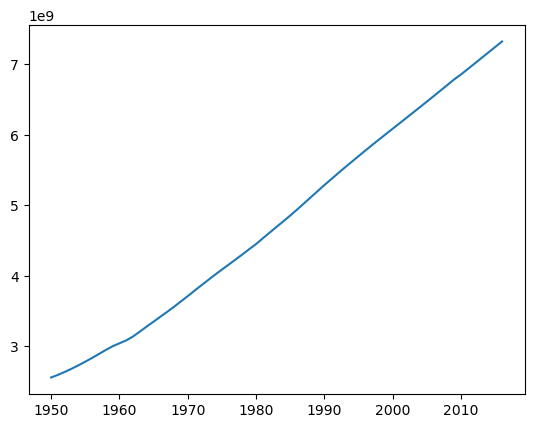

In [123]:
plt.plot(t, X)

### Ajustar a diferentes modelos

Se definen todos los modelos a los que se desea ajustar:

In [124]:
def model_linear(slope):
    def f(x, t):
        return np.array([slope])
    return f

def model_exp(r):
    def f(x, t):
        return np.array([r*x])
    return f

def model_logistic(r,k):
    def f(x, t):
        return np.array([r*x*(1-x/k)])
    return f

def model_gompertz(a,b):
    def f(x, t):
        return np.array([a*x - b*x*np.log(x)])
    return f

def model_putter(a,b,alpha,beta):
    def f(x, t):
        return np.array([a*x**alpha - b*x**beta])
    return f

In [125]:
def solve_ode(model, x0, t):
    n = len(t)
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i]
        x[i+1] = x[i] + dt * model(x[i], t[i])
    return x

In [126]:
def error_func_factory(model):
    def err_func(params):
        x_hat = solve_ode(model(*params), X[0], t)
        return X - x_hat
    return err_func
    

In [127]:
models = [
    ('linear', model_linear, [2e8]),
    ('exponential', model_exp, [1.5]),
    ('logistic', model_logistic, [1.5, 12e9]),
    ('gompertz', model_gompertz, [1.5, 1e-9]),
    ('putter', model_putter, [0.2, 0.2, 1.1, 1.1]),
]

In [128]:
from scipy.optimize import leastsq

params = []

for name, model, param0 in models:
    err_fn = error_func_factory(model)
    param_hat = leastsq(err_fn, param0, maxfev=50_000)
    print(f"Model {name}, optimal params: {param_hat}")
    params.append(param_hat)

Model linear, optimal params: (array([69337493.4187876]), 2)
Model exponential, optimal params: (array([0.01704146]), 1)
Model logistic, optimal params: (array([2.55578876e-02, 1.29434832e+10]), 1)
Model gompertz, optimal params: (array([0.21087262, 0.00875229]), 1)
Model putter, optimal params: (array([0.20831357, 0.20415975, 1.18955926, 1.19041272]), 2)


In [129]:
adjusted_models = [
    (name, model, param)
    for (param, _), (name, model, _)
    in zip(params, models)
]

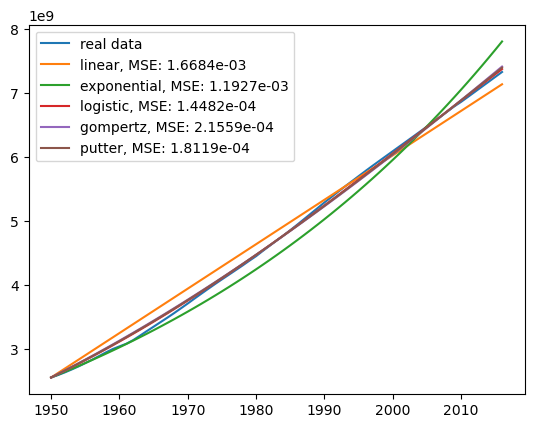

In [131]:
plt.plot(t, X, label="real data")

for name, model, param_hat in adjusted_models:
    X_hat = solve_ode(model(*param_hat), X[0], t)
    MSE = (np.square((X_hat - X)/X) / len(X)).sum()
    plt.plot(t, X_hat, label=f"{name}, MSE: {MSE:.4e}")
plt.legend()
plt.show()

### Simulación y estimación a largo plazo

Se simulan los 5 parametros con sus parametros ajustados hasta el año 2400

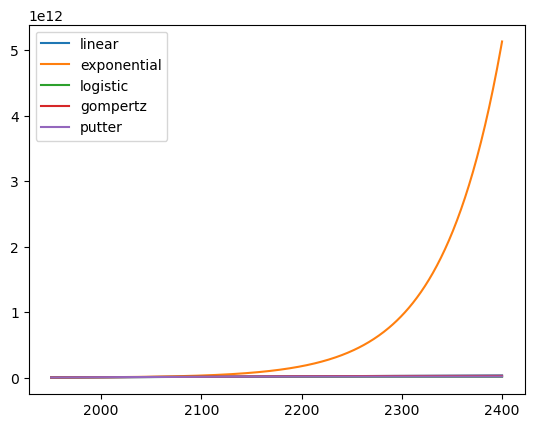

In [37]:
t_star = np.linspace(1950, 2400,2400-1950+1)

for name, model, param_hat in adjusted_models:
    X_hat = solve_ode(model(*param_hat), X[0], t_star)
    plt.plot(t_star, X_hat, label=name)
plt.legend()
plt.show()

El exponencial completamente explota, haciendo los otros modelos indistinguibles entre ellos, con lo que se usan los mismos datos sin el exponencial

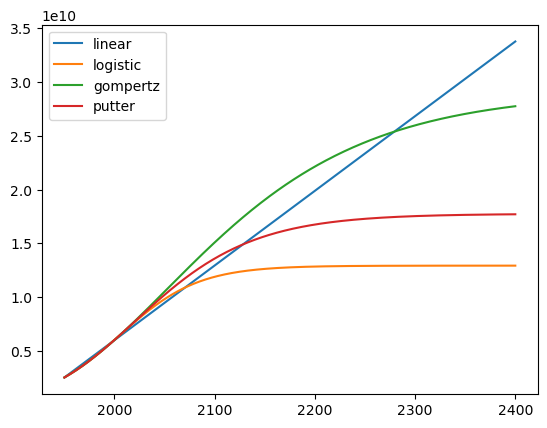

In [38]:

for name, model, param_hat in adjusted_models:
    if name == 'exponential':
        continue
    X_hat = solve_ode(model(*param_hat), X[0], t_star)
    plt.plot(t_star, X_hat, label=name)
plt.legend()
plt.show()

Se ve que el modelo linear sigue, evidentemente, un simple crecimiento linear, mientras que los otros se nivelan parecido al comportamiento de una curva logística.

Para encontrar el equilibrio se puede encontrar los puntos de equilibrio analíticamente. Para no tener que integrar analíticamente, solo se usa la derivada y se busca sus puntos zero.

#### Modelo Logistico

\begin{align*}
    \dot{x} &= r \cdot x \cdot \left( 1 - \frac{x}{k} \right) \\
    0 &= r \cdot x \cdot \left( 1 - \frac{x}{k} \right) \\
    0 &= x \cdot \left( 1 - \frac{x}{k} \right) \\
    0 &= x (1 - \frac{x}{k}) \\
\end{align*}

desarollado se ve que los dos puntos de equilibrio son en $x = 0$ y en $x=k$, ignorando el caso de $0$, se ve que el equilibrio con este modelo es el parametro k.

In [39]:
pop_logistic = adjusted_models[2][2][1]
print(f"population equilibrium using logistic model: {pop_logistic:,.0f}")

population equilibrium using logistic model: 12,943,483,216


#### Modelo Gompertz

\begin{align*}
    \dot{x} &= ax - bx\log x \\
    0 &= ax - bx \log x \\
    0 &= x (a-b \log x) \\
\end{align*}

se ignora el caso de población 0

\begin{align*}
    0 &= a-b \log x \\
    b \log x &= a \\
    \log x &= \frac{a}{b}\\
    x &= \exp{\frac{a}{b}}
\end{align*}

In [40]:
a, b = adjusted_models[3][2]
pop_gompertz = np.exp(a/b)
print(f"population equilibrium using gompertz model: {pop_gompertz:,.0f}")

population equilibrium using gompertz model: 29,083,095,939


#### Modelo Putter

\begin{align*}
    \dot{x} &= ax^\alpha - bx^\beta \\
    0 &= ax^\alpha - bx^\beta \\
    0 &= x^\alpha \left(a - bx^{(\beta-\alpha)}\right)
\end{align*}

Una solucion es $x^\alpha = 0$, que coincide con la solución zero

La otra es:

\begin{align*}
    0 &= a - bx^{(\beta-\alpha)} \\
    a  &= bx^{(\beta-\alpha)} \\
    \frac{a}{b} &= x^{(\beta-\alpha)} \\
    x &= \left(\frac{a}{b}\right)^\frac{1}{\beta-\alpha}
\end{align*}

In [42]:
a, b, alpha, beta = adjusted_models[4][2]
estimated_pop = (a/b)**(1/(beta-alpha))
print(f"population equilibrium using putter model: {estimated_pop:,.0f}")

population equilibrium using putter model: 17,756,794,663


### Elección de modelo fiable

En mi opinión, me quedaría con el modelo logístico,
dado que con el lineal y exponencial, no tienen límite superior,
y con los otros dos modelos que se puede sospechar sobreajuste en estos.
Además, el logístico tuvo el menor error.

### Ejercicio 2

Vamos a partir del **modelo mínimo** realizado en clase, que explica el proceso de regulación de la glucosa en sangre debido a la acción de la insulina. El modelo es: 

$$\begin{array}{l}\displaystyle{\dot{B}} = -k_1 \left[ B - B_b \right] - X B,\\
\displaystyle{\dot{X}} = k_3 \left[I(t) - I_b \right] - k_2 X,\end{array}$$ 

donde $B$ y $X$ son las concentraciones de glucosa en sangre y de insulina en el fluido del tejido celular, respectivamente. La función $I(t)$ indica la concentración de insulina en sangre, que tomamos exógena de este [archivo](https://github.com/AllenDowney/ModSim/raw/main/data/glucose\_insulin.csv). Los parámetros $B_b$ e $I_b$ son los niveles basales de glucosa e insulina en sangre, mientras que $k_1$, $k_2$ y $k_3$ son parámetros positivos. Tomamos como valores iniciales de los parámetros aquellos propuestos en el ejercicio realizado en clase.

En este ejercicio asumimos que la producción de insulina es endógena al sistema, y se propone que sigue la siguiente ecuación a añadir a las anteriores: 

$$ \dot{I} = -k I + \gamma (B - B_T)t $$

siendo $k$, $\gamma$ y $B_T$ parámetros del modelo.

**(a)** Interpretar la ecuación de la insulina. O sea, indicar qué factores hacen que crezca la insulina y qué factores hacen que disminuya. ¿Cómo se interpretaría el parámetro $B_T$?

**(b)** Simular el nuevo modelo con valores iniciales de $k = 0.25$, $\gamma = 0.004$ y $B_T = 80$ y unos niveles de insulina iniciales de $I_0=360$. Ajustar los parámetros del modelo de forma que se represente lo mejor posible los datos reales a partir de la cuarta toma. Estimar el error cuadrático medio obtenido.      

**(c)** Existen dos medidas biológicas que se construyen a partir de los parámetros del modelo:

$$ \begin{array}{l}\phi_1 = \frac{I_{max} - I_b}{k (B_0 - B_b)}\\
    \phi_2 = \gamma \times 10^4\end{array} $$
   
Según algunos autores, los valores esperados de estos parámetros están entre 2 y 4 para $\phi_1$ y 20 y 35 para $\phi_2$. Comprobar si con el ajuste realizado los valores de estas medidas están en los rangos esperados.  

In [139]:
import pandas as pd

k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
B0 = 270
X0 = 0

insulin_df = pd.read_csv("glucose_insulin.csv")

Bb = insulin_df["glucose"].iloc[0]
Ib = insulin_df["insulin"].iloc[0]

insulin_df.head()

,time,glucose,insulin
0,0,92,11
1,2,350,26
2,4,287,130
3,6,251,85
4,8,240,51


In [140]:
def insulin_model(k, gamma, k1, k2, k3, Bb, Ib, BT):
    def f(x, t):
        return np.array([
            k1 * (Bb - x[0] ) - x[1] * x[0],
            k3 * (x[2] - Ib) - k2*x[1],
            -k * x[2] + gamma * (x[0] - BT)*t
        ])
    return f


#### Interpretación de insulina endógena

Semanticamente dividiría el modelo en dos partes, en $-kI$, que indica
que la insulina disminuye de una manera exponencial negativa
proporcionalmente a la insulina presente; y $\gamma(B-B_T)t$,
en la cual la insulina cambia en función de la diferencia de glucosa que hay comparado con $B_T$, atenuado por un factor $\gamma$.

La interpretación de $B_T$ es el nivel de glucosa "base", tal que cuando la glucosa esta a este nivel, la insulina no cambia aparte de su bajada proporcional a si misma de la sangre.

### Simulación y ajuste

In [141]:
k = 0.25
gamma = 0.004
B_T = 80

I0 = 360

In [142]:
def solve_ode(model, x0, t):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i]
        x[i+1] = x[i] + dt * model(x[i], t[i])
    return x

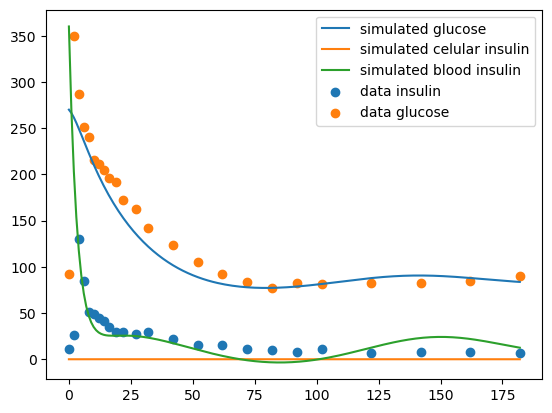

In [143]:
x0 = np.array([B0, X0, I0])

t = np.linspace(0, 182, 183)

x = solve_ode(insulin_model(k, gamma, k1, k2, k3, Bb, Ib, B_T), x0, t)

plt.plot(t, x[:,0], label="simulated glucose")
plt.plot(t, x[:,1], label="simulated celular insulin")
plt.plot(t, x[:,2], label="simulated blood insulin")
plt.scatter(insulin_df["time"], insulin_df["insulin"], label="data insulin")
plt.scatter(insulin_df["time"], insulin_df["glucose"], label="data glucose")
plt.legend()
plt.show()

In [144]:
X_dat = insulin_df.iloc[:,1:].to_numpy()
t_dat = insulin_df["time"].to_numpy()
X_dat.shape, t_dat.shape

((24, 2), (24,))

In [147]:
def err_func(params):
    X_hat = solve_ode(insulin_model(*params), x0, t)
    X_hat_dat = np.array([np.interp(t_dat, t, X_hat[:,i]) for i in (0,2)]).T
    err = X_dat - X_hat_dat

    return err[3:].flatten()


In [155]:
params_0 = np.array([k, gamma, k1, k2, k3, Bb, Ib, B_T])

params_hat = leastsq(err_func, params_0)
params_hat

(array([ 2.20191875e-01,  3.33753962e-03,  1.97010939e-02,  3.46228474e-02,
         9.58618037e-06,  1.66683902e+02, -6.32007527e+01,  7.94470708e+01]),
 1)

In [156]:
t_dat.shape, X_dat.shape

((24,), (24, 2))

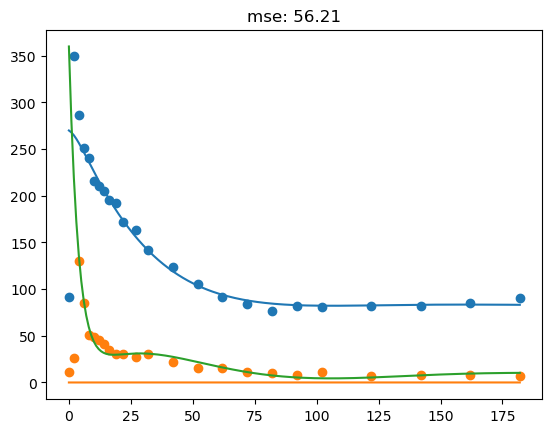

In [171]:
x_adj = solve_ode(insulin_model(*params_hat[0]), x0, t)

X_adj_dat = np.array([np.interp(t_dat, t, x_adj[:,i]) for i in (0,2)]).T
err = (X_adj_dat - X_dat)[:3]

mse = np.sqrt(np.square(err)/X_dat[:3]).sum() / len(err)

plt.title(f"mse: {mse:.2f}")
plt.plot(t, x_adj)
plt.scatter(t_dat, X_dat[:,0])
plt.scatter(t_dat, X_dat[:,1])
plt.show()

In [151]:
k_hat, gamma_hat, k1_hat, k2_hat, k3_hat, Bb_hat, Ib_hat, B_T_hat = params_hat[0]

In [165]:
phi_1 = (x_adj[:,2].max() - Ib_hat) / (k_hat*(x0[0]-Bb_hat))
phi_2=gamma_hat*1e4

print(f"phi_1 = {phi_1}")
print(f"phi_2 = {phi_2}")

phi_1 = 18.602749780150177
phi_2 = 33.37539620143653


$\phi_2$ esta en el rango correcto, pero $\phi_1$ no.